In [1]:
# mouting google drive to import data saved on it
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#installing the transformers package needed for NLP tasks involving transofrmers such as BERT
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import json
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

In [4]:
# loading the question-answer pairs file
s08 = pd.read_csv('/content/QA Pairs.txt', sep='\t', encoding = 'ISO-8859-1')
# loading contexts for the above pairs
contexts = pd.read_csv('/content/Context.txt', sep='\n', encoding = 'ISO-8859-1', header=None)
# loading the testing questions (anonymous question not in the dataset) and their answers and context
test_set = pd.read_csv('/content/test2.txt', sep='\t', encoding = 'ISO-8859-1')

In [5]:
# making a new variable to manipulate the data while keeping the original
trn = s08

In [6]:
# dropping columns which we will not use and removing any NAN values then resetting the index for each set of data
trn = trn.drop(columns = ['DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleTitle'])

In [9]:
# randomly selecting samples from the train set for validation
val= trn.sample(10)

In [10]:
# getting the validation contexts of the samples that were selected
val_contexts= []
for i in range(len(val)):
  val_contexts.append(contexts[0][val.index[i]])

# storing the train contexts in a list instead of a dataframe
train_contexts= []
for i in range(len(contexts)):
  train_contexts.append(contexts[0][i])

In [11]:
# resetting the indices of validation and training sets
val = val.reset_index(drop=True)
trn = trn.reset_index(drop=True)

In [12]:
# preparing train & validation questoins
train_questions = trn['Question'].values.tolist()
val_questions = val['Question'].values.tolist()

# storing the test questions and contexts in lists
test_questions= test_set['Question'].values.tolist()
test_contexts= test_set['Context'].values.tolist()

In [13]:
# preparing the train answers in json format (with the answer's start/end positions in their contexts)
train_answers = []
for i in range(len(trn)):
  src_str = train_contexts[i]
  start_index = src_str.find(trn['Answer'][i])
  end_index = start_index + len(trn['Answer'][i])
  train_answers.append(str("{\"text\": \"" + trn['Answer'][i] + str("\", \"answer_start\": ") + 
                           str(start_index) + str(", \"answer_end\": ") + str(end_index) + str("}")))
  
# preparing the validation answers in json format (with the answer's start/end positions in their contexts)
val_answers = []
for i in range(len(val)):
  src_str = val_contexts[i]
  start_index = src_str.find(val['Answer'][i])
  end_index = start_index + len(val['Answer'][i])
  val_answers.append(str("{\"text\": \"" + val['Answer'][i] + str("\", \"answer_start\": ") + 
                           str(start_index) + str(", \"answer_end\": ") + str(end_index) + str("}")))
  
# prepating the test answers in json format (with the answer's start/end positions in their contexts)
test_answers = []
for i in range(len(test_set)):
  src_str = test_contexts[i]
  start_index = src_str.find(test_set['Answer'][i])
  end_index = start_index + len(test_set['Answer'][i])
  test_answers.append(str("{\"text\": \"" + test_set['Answer'][i] + str("\", \"answer_start\": ") + 
                           str(start_index) + str(", \"answer_end\": ") + str(end_index) + str("}")))

In [14]:
# visualizing/checking the context, question, and answer pairs
i=40
print(train_contexts[i])
print(train_questions[i])
print(train_answers[i], "\n")

i=9
print(val_contexts[i])
print(val_questions[i])
print(val_answers[i], "\n")

i=0
print(test_contexts[i])
print(test_questions[i])
print(test_answers[i])

Romania is a secular state, thus having no national religion. The dominant religious body is the Romanian Orthodox Church; its members make up 86.7% of the population according to the 2002 census. Other important religions include Roman Catholicism (4.7%), Protestantism (3.7%), Pentecostal denominations (1.5%) and the Romanian Greek-Catholic Church (0.9%).  Romania also has a historically significant Muslim minority concentrated in Dobrogea, mostly of Turkish ethnicity and numbering 67,500 people.     Romanian Census Website with population by religion  Based on the 2002 census data, there are also 6,179 Jews, 23,105 people who are of no religion and/or atheist, and 11,734 who refused to answer. On December 27, 2006, a new Law on Religion was approved under which religious denominations can only receive official registration if they have at least 20,000 members, or about 0.1 percent of Romania's total population.  Romania President Approves Europe's "Worst Religion Law"
Why doesn't Rom

In [15]:
i=6
print(test_contexts[i])
print(test_questions[i])
print(test_answers[i])

Romania is a secular state, thus having no national religion. The dominant religious body is the Romanian Orthodox Church; its members make up 86.7% of the population according to the 2002 census. Other important religions include Roman Catholicism (4.7%), Protestantism (3.7%), Pentecostal denominations (1.5%) and the Romanian Greek-Catholic Church (0.9%).  Romania also has a historically significant Muslim minority concentrated in Dobrogea, mostly of Turkish ethnicity and numbering 67,500 people.     Romanian Census Website with population by religion  Based on the 2002 census data, there are also 6,179 Jews, 23,105 people who are of no religion and/or atheist, and 11,734 who refused to answer. On December 27, 2006, a new Law on Religion was approved under which religious denominations can only receive official registration if they have at least 20,000 members, or about 0.1 percent of Romania's total population.  Romania President Approves Europe's "Worst Religion Law"
Is Romania a re

In [16]:
# initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# tokenize
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True)

In [17]:
# checking one of the encoded inputs to observe the tokens
tokenizer.decode(train_encodings['input_ids'][30])

'[CLS] a collision with a vehicle is capable of killing a kangaroo. kangaroos dazzled by headlights or startled by engine noise have been known to leap in front of cars. since kangaroos in mid - bound can reach speeds of around 50 km / h ( 31 mph ) and are relatively heavy, the force of impact can be severe. small vehicles may be destroyed, while larger vehicles may suffer engine damage. the risk of harm to vehicle occupants is greatly increased if the windscreen is the point of impact. as a result, " kangaroo crossing " signs are commonplace in australia. [SEP] is a collision with a vehicle capable of killing a kangaroo? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [18]:
# transforming the answers from strings to json formats to access and use the values/info easily later
for i in range(len(train_answers)):
  train_answers[i]= json.loads(train_answers[i])

for i in range(len(val_answers)):
  val_answers[i]= json.loads(val_answers[i])

for i in range(len(test_answers)):
  test_answers[i]= json.loads(test_answers[i])

In [19]:
# defining a function to add the answers and the needed tokens to the encoded training and validation
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift position until found
        shift = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - shift)
            shift += 1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# apply function to our data
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
add_token_positions(test_encodings, test_answers)

In [20]:
#checking the encoding keys
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [21]:
# defining a class to prepare and build the sets in the appropriate format for training
class QA_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# build datasets for both our training and validation sets
train_dataset = QA_dataset(train_encodings)
val_dataset = QA_dataset(val_encodings)
test_dataset = QA_dataset(test_encodings)

In [22]:
# building the model
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

In [23]:
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

losses=[]

# start the training, with the number of epochs manipulated in the range
for epoch in range(13):
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        #save loss in a list to plot
        losses.append(loss.item())

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s, loss=0.406]


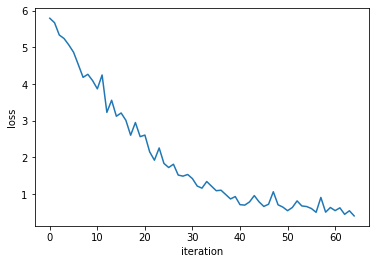

In [24]:
plt.plot(range(0,65), losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

In [25]:
#save the model in case it is needed later
model_path = '/content/models'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/models/tokenizer_config.json',
 '/content/models/special_tokens_map.json',
 '/content/models/vocab.txt',
 '/content/models/added_tokens.json',
 '/content/models/tokenizer.json')

In [26]:
#load model for later use if needed
#model_path = '/content/models'
#model = DistilBertForQuestionAnswering.from_pretrained(model_path)
#tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

In [27]:
# switch model out of training mode
model.eval()

ds= val_dataset
#ds= test_dataset
set_loader = DataLoader(ds, batch_size=10)

acc = []

# initialize loop for progress bar
loop = tqdm(set_loader)
# loop through batches
for batch in loop:
    # we don't need to calculate gradients as we're not training
    with torch.no_grad():
        # pull batched items from loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
        # make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        # pull preds out
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        # calculate accuracy for both and append to accuracy list
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

# calculate average accuracy in total
acc = sum(acc)/len(acc)
print("\nAccuracy= ", acc*100, "%")

100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Accuracy=  85.00000238418579 %


In [28]:
print("#\ttype\tstart\tend\n")
for i in range(len(start_true)):
    print(f"{i}\ttrue\t{start_true[i]}\t{end_true[i]}\n"
          f"\tpred\t{start_pred[i]}\t{end_pred[i]}\n")

#	type	start	end

0	true	14	23
	pred	14	23

1	true	13	33
	pred	13	12

2	true	22	29
	pred	22	29

3	true	1	8
	pred	1	8

4	true	206	221
	pred	206	221

5	true	38	44
	pred	38	44

6	true	1	8
	pred	1	8

7	true	73	80
	pred	73	31

8	true	4	16
	pred	1	16

9	true	7	17
	pred	7	17



In [29]:
if ds == test_dataset:
  for i in range(len(start_true)):
    print("\nQuestion (", i, "): ", test_questions[i])
    print("True answer: ", test_answers[i]['text'])
    print("Predicted answer:")
    answer = tokenizer.decode(batch['input_ids'][i][start_pred[i] : end_pred[i]])
    print(answer)

if ds == val_dataset:
  for i in range(len(start_true)):
    print("\nQuestion (", i, "): ", val_questions[i])
    print("True answer: ", val_answers[i]['text'])
    print("Predicted answer:")
    answer = tokenizer.decode(batch['input_ids'][i][start_pred[i] : end_pred[i]])
    print(answer)


Question ( 0 ):  What happened in 1896?
True answer:  Becquerel accidentally discovered radioactivity.
Predicted answer:
becquerel accidentally discovered radioactivity

Question ( 1 ):  Have Kangaroos dazzled by headlights or startled by engine noise been known to leap in front of cars ?
True answer:  Kangaroos dazzled by headlights or startled by engine noise have been known to leap in front of cars.
Predicted answer:


Question ( 2 ):  Is the president elected by popular vote?
True answer:  The president is elected by popular vote
Predicted answer:
the president is elected by popular vote

Question ( 3 ):  Is romania a semi-presidential unitary state?
True answer:  Romania is a semi-presidential democratic republic
Predicted answer:
romania is a semi - presidential democratic

Question ( 4 ):  What may be called Volta's Law of the electrochemical series?
True answer:  two identical electrodes and a common electrolyte give zero net emf
Predicted answer:
two identical electrodes and 